# Relatorio - Machine Learning

## Introdução
O Índice de Desenvolvimento Humano (IDH), criado pelo Programa das Nações Unidas para o Desenvolvimento (Pnud) em 1990, se tornou um indicador fundamental para avaliar o bem-estar social de países e regiões. Mais do que um simples ranking, o IDH oferece uma visão holística do desenvolvimento humano, considerando aspectos essenciais da vida das pessoas, como saúde, educação e renda.

O IDH se destaca por sua abrangência ao considerar três pilares básicos:

- Saúde: Medida pela expectativa de vida ao nascer, que reflete o acesso a serviços de saúde e qualidade de vida.
- Educação: Medida pela média de anos de escolaridade e anos esperados de escolaridade, que indicam o nível de educação da população e oportunidades de aprendizado.
- Renda: Medida pelo PIB per capita ajustado pela paridade do poder de compra (PPC), que reflete o padrão de vida e acesso a bens e serviços.
Ao combinar esses indicadores em um único valor entre 0 e 1, o IDH permite comparações simples e intuitivas entre países e regiões, facilitando a análise de tendências e disparidades no desenvolvimento humano.

Os dados são distribuidos da seguinte forma <a href = https://hdr.undp.org/sites/default/files/2023-24_HDR/hdr2023-24_technical_notes.pdf>(1)</a>

| Dimensão | Indicador                        | Minimo | Maximo |
|----------|----------------------------------|--------|--------|
| Saude    | Expectativa de vida desde o nascimento | 20 | 85 |
| Educação | Tempo esperado em anos na escola | 0 | 18 |
| ''       | Tempo medio esperados em anos na escola | 0 | 15 |
| Renda    | PIB _per capita_ | 100 | 75_000 |
 
O index da dimensão dos dados eles serão ponderados e calculados da seguinte maneira:

$$ Dimensão index = \frac{valor atual - valor minimo}{valor maximo - valor minimo} $$

> No caso da dimensão de educação os dois indicadores são calculados individualmente, em seguida, o
é obtida a média aritmética dos dois índices resultantes.

No fim o IDH é a média geométrica dos índices tridimensionais.

$$ IDH = \sqrt[3]{(I_{Saude} * I_{Educacao} * I_{Renda})} $$

## Motivação

O IDH podera sobre 3 dimensões, saude, educação e renda. Porem o presente trabalho visa em tentar entender a classificação de paises pelo seu IDH para alem dos valores do proprio IDh. Utilizamos o IDH para criar uma metrica de paises pouco desenvolvidos (IDH < 0.5) e paises desenvolvidos (IDH >= 0.5).

Após isso selecionamos, após varias analises, testes e observações, 10 indicadores do <a href = 'https://data.worldbank.org'> World Data Bank </a> (Ferramenta mundial para armazenamento de indicadores me diversas areas da politica pública e internacional). Os indicadores foram todos extraídos do topico de <a href = 'https://data.worldbank.org/topic/social-development?view=chart'> Desenvolvimento Social. </a>

Por fim, os dados foram pareados com os anos de coleta dos dados de IDH do <a href = 'https://ourworldindata.org'> Our World in Data </a>.



In [2]:
import pandas as pd
import random as rd
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from sklearn import model_selection, metrics
from sklearn.metrics import accuracy_score
from keras import regularizers
import numpy as np

In [3]:
BATCH_SIZE = 32
RANDOM_SEED = 42

# Dados

## explorando dados

In [4]:
df_data = pd.read_csv('class_results.csv')

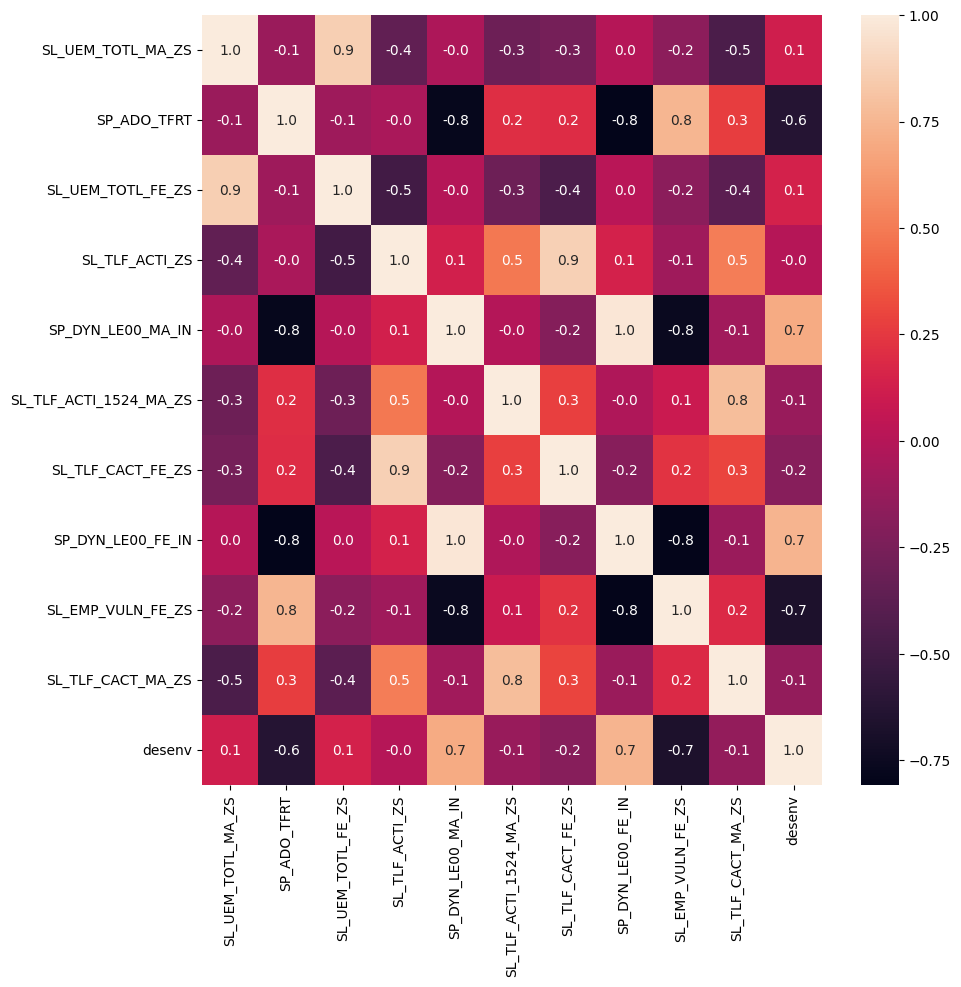

In [5]:
plt.figure(figsize=(10,10))
sns.heatmap(df_data.corr(), annot=True, fmt='.1f')
plt.show()

## Divisão dos dados
Adotaremos a regra de ouro 80, 20:
- 80% de dados para treino
- 20% de dados para teste

In [6]:
#ma antes vamos deixar os dados igualmente separados
data_aux = df_data.loc[df_data['desenv'] == 0]
data_aux_2 = df_data[df_data['desenv'] == 1].sample(min(df_data['desenv'].value_counts())) 
df_data = pd.concat([data_aux, data_aux_2])

In [7]:
X_data = np.array(df_data.drop(['desenv'], axis=1))
y_data = np.array(df_data['desenv'])

X_train, X_test, y_train, y_test = model_selection.train_test_split(X_data, y_data, random_state=RANDOM_SEED, test_size=0.2)

print("Train: ", X_train.shape, y_train.shape)
print("Test: ", X_test.shape, y_test.shape)

Train:  (1667, 10) (1667,)
Test:  (417, 10) (417,)


# MODELOS

## Rede neural

## Configurações
### Dimensão VC
No total temos 5007 dados para serem treinados no modelo e a dimensão VC tem a seguinte formula para redes neurais:

$$  n \ge 10 * W $$
> W - peso do modelo

O peso do rede W pode ser representado pela seguinte equação
$$ W = (d+1) * Q_{de} + (d+1) $$
> d - Dimensao de cada amostra  <br>
> Q_ce - Quantide de Camadas Escondidas <br>

Logo, supondo que teremos 1 camada escondida

$$ W =  (10+1) * 1 + (10+1) = 22 $$ 
$$ n \ge 22*10 = 220 $$

220 dados são suficientes para generalizar

### Regra de ouro
Assim, agora precisamos determinar a quantidade de neuronios que serão utilizados nas camadas ocultas. Para isso podemos utilizar o seguinte artificio matematico:

$$ n \le \frac{|DS| - 10}{10(d + n_e)} $$
> DS - Numero de amostras no dataset de treino <br>
> n_e - Numero de camadas escondidas <br>
> d - numero de _features_ <br>

assim,

$$ n \le \frac{1667-10}{10*(10+2)} <=> \frac{1657}{120} \equiv 14 $$

In [24]:
# 1 camada oculta
# 10 valores de entrada
# 14 neuronios na camada oculta

# Criando a arquitetura da rede neural
model = Sequential()

# Rede configurada a partir de informações da dimensão VC e da regra de ouro
model.add(Dense(14, input_dim=10, kernel_initializer='normal', activation='tanh'))
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

#utilizado a função de ativação tanh para que a saida possa variar entre 0 e 1

# Instanciação e configuração de otimizadores
sgd = optimizers.SGD(learning_rate=0.01)

# Compila o modelo
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

print(model.summary())

c:\Users\Xonas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 14)             │           154 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            15 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 169 (676.00 B)

 Trainable params: 169 (676.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [25]:

# X_train, X_test, y_train, y_test

model_hdi = model.fit(X_train, y_train, epochs=100, batch_size=BATCH_SIZE)

Epoch 1/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7864 - loss: 0.6148 
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8957 - loss: 0.4287
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8846 - loss: 0.3551
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9030 - loss: 0.3066
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9145 - loss: 0.2837
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9163 - loss: 0.2612
Epoch 7/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9183 - loss: 0.2524
Epoch 8/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9250 - loss: 0.2271
Epoch 9/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9239 - loss: 0.2257
Epoch 10/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9235 - loss: 0.2453
Epoch 11/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9305 - loss: 0.2231
Epoch 12/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

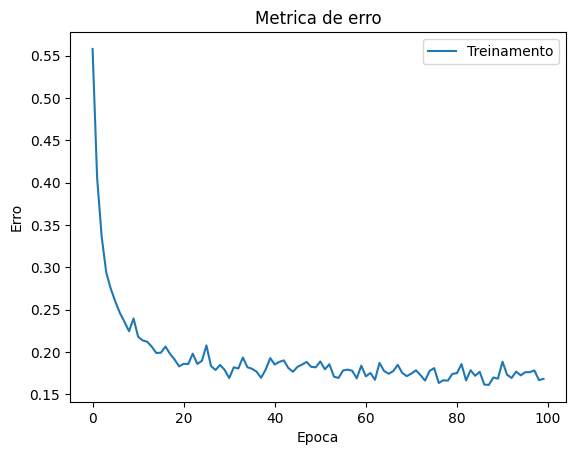

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

--> Acuracia (treino): 0.9460
--> Acuracia (teste): 0.9424
--> E_out - E_in = 0.0235
--> acc_train - acc_test = 0.0035


In [26]:

plt.plot(model_hdi.history['loss'])
plt.title('Metrica de erro')
plt.ylabel('Erro')
plt.xlabel('Epoca')
plt.legend(['Treinamento'])
plt.show()

# Obtendo a acuracia usando accuracy_score()
pred = np.round(model.predict(X_train))
acc_train = accuracy_score(y_train, pred)

# Obtendo a acuracia usando evaluate()
E_out, acc_test = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)

print(f'\n--> Acuracia (treino): {acc_train:.4f}')
print(f'--> Acuracia (teste): {acc_test:.4f}')
print(f"--> E_out - E_in = {E_out - model_hdi.history['loss'][-1]:.4f}")
print(f"--> acc_train - acc_test = {acc_train - acc_test:.4f}")

### Validation

c:\Users\Xonas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


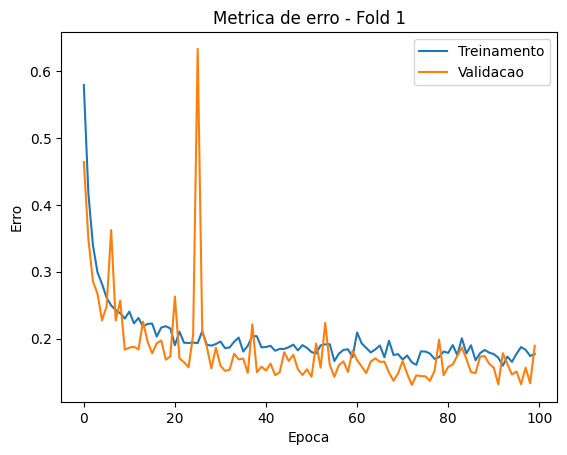

--> Acuracia (treino): 0.9392
--> Acuracia (validacao): 0.9401
--> E_val - E_in = 0.0121
--> acc_in - acc_val = -0.0009



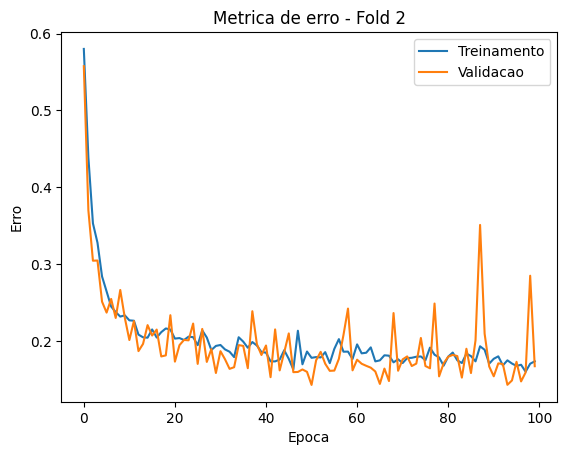

--> Acuracia (treino): 0.9370
--> Acuracia (validacao): 0.9431
--> E_val - E_in = -0.0063
--> acc_in - acc_val = -0.0061



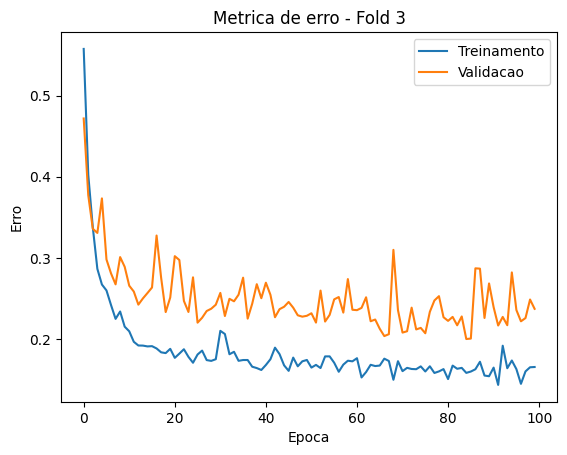

--> Acuracia (treino): 0.9558
--> Acuracia (validacao): 0.9309
--> E_val - E_in = 0.0717
--> acc_in - acc_val = 0.0248



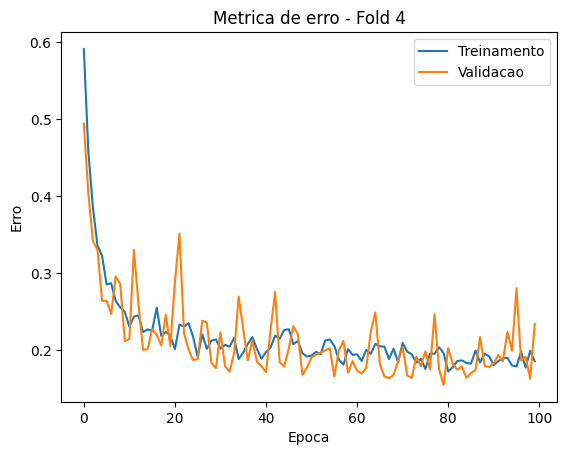

--> Acuracia (treino): 0.9003
--> Acuracia (validacao): 0.9129
--> E_val - E_in = 0.0485
--> acc_in - acc_val = -0.0126



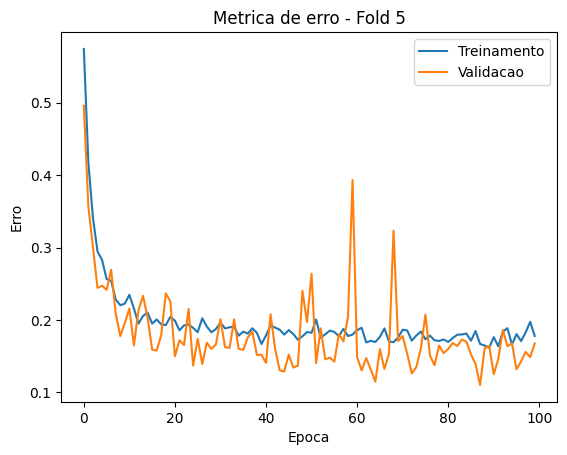

--> Acuracia (treino): 0.9333
--> Acuracia (validacao): 0.9219
--> E_val - E_in = -0.0105
--> acc_in - acc_val = 0.0114



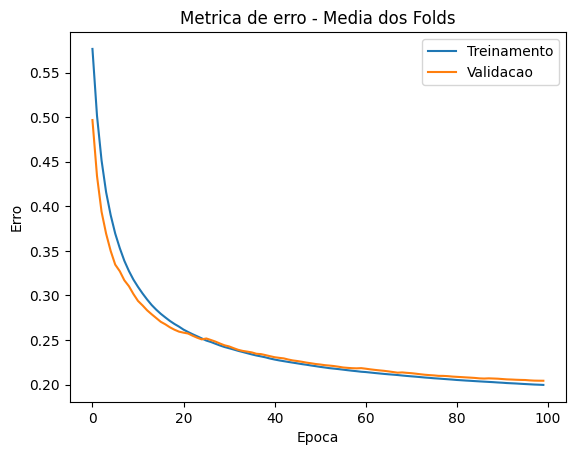

--> Acuracia (treino): 0.9331
--> Acuracia (validacao): 0.9298
--> E_val - E_in = 0.0047
--> acc_in - acc_val = 0.0114



In [27]:
from sklearn.model_selection import StratifiedKFold

#retirando 20% dos dados para validacao
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_data, y_data, random_state=RANDOM_SEED, test_size=0.2)

# Garante o balanceamento nos folds
skf = StratifiedKFold(n_splits=5, shuffle=True)

accuracies_train = []
accuracies_val = []
history_list = []

# Realiza o k-fold cross validation
i = 0
for train_index, val_index in skf.split(X_train, y_train):
    i = i + 1
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    model = Sequential()
    # Rede configurada a partir de informações da dimensão VC e da regra de ouro
    model.add(Dense(14, input_dim=10, kernel_initializer='normal', activation='tanh'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

    # Instanciação e configuração de otimizadores
    sgd = optimizers.SGD(learning_rate=0.01)

    # Compila o modelo
    model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
  
    # Treina o modelo
    history = model.fit(X_train_fold, y_train_fold, validation_data=(X_val_fold, y_val_fold), epochs=100, batch_size=BATCH_SIZE, verbose=0)
    history_list.append(history) 
    
    # Avalia o modelo
    _, accuracy_train = model.evaluate(X_train_fold, y_train_fold, batch_size=BATCH_SIZE, verbose=0)
    _, accuracy_val = model.evaluate(X_val_fold, y_val_fold, batch_size=BATCH_SIZE, verbose=0)
    accuracies_train.append(accuracy_train)
    accuracies_val.append(accuracy_val)
    
    # Exibe o historico de treinamento para um fold especifico
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Metrica de erro - Fold {i}')
    plt.ylabel('Erro')
    plt.xlabel('Epoca')
    plt.legend(['Treinamento', 'Validacao'])
    plt.show()

    print(f'--> Acuracia (treino): {accuracy_train:.4f}')
    print(f'--> Acuracia (validacao): {accuracy_val:.4f}')
    print(f"--> E_val - E_in = {(history.history['val_loss'][-1] - history.history['loss'][-1]):.4f}")
    print(f"--> acc_in - acc_val = {accuracy_train - accuracy_val:.4f}\n")    

# Calcula a acuracia media
avg_accuracy_train = np.mean(accuracies_train)
avg_accuracy_val = np.mean(accuracies_val)

# Historico com valores medios dos folds
history_loss_avg = []
history_val_loss_avg = []
aux_list1 = []
aux_list2 = []

for i in range(len(history.history['loss'])):
    for j in range(len(history_list)):
        aux_list1.append(history_list[j].history['loss'][i])
        aux_list2.append(history_list[j].history['val_loss'][i])
    history_loss_avg.append(np.mean(aux_list1))
    history_val_loss_avg.append(np.mean(aux_list2))                            
                   
plt.plot(history_loss_avg)
plt.plot(history_val_loss_avg)
plt.title('Metrica de erro - Media dos Folds')
plt.ylabel('Erro')
plt.xlabel('Epoca')
plt.legend(['Treinamento', 'Validacao'])
plt.show()

print(f'--> Acuracia (treino): {avg_accuracy_train:.4f}')
print(f'--> Acuracia (validacao): {avg_accuracy_val:.4f}')
print(f"--> E_val - E_in = {(history_val_loss_avg[-1] - history_loss_avg[-1]):.4f}")
print(f"--> acc_in - acc_val = {accuracy_train - accuracy_val:.4f}\n")    


In [ ]:
# MATRIZ DE CONFUSAO
y_pred_test = model.predict(X_test)
y_pred_test = [round(y[0]) for y in y_pred_test]
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred_test).flatten()

acc = (tn+tp)/(tn+fp+tp+fp)
precis = (tp)/(tp+fp)
recall = (tp)/(tp+fn)
f1_score = 2 *(precis*recall)/(precis+recall)
print('================= MATRIZ DE CONFUSAO =======================')
print('REDE NEURAL')
print(f'           Negativo | Positivo              ')
print(f'Negativo   {tn}     |   {fp}                ')
print(f'Positivo   {fn}     |   {tp}                ')
print(f'===========================================================')
print(f'Acuracia = {acc}')
print(f'Precisao = {precis}')
print(f'Recall = {(tp)/(tp+fn)}')
print(f'f1-Score =  {f1_score}')


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
================= MATRIZ DE CONFUSAO =======================
REDE NEURAL
           Negativo | Positivo              
Negativo   222     |   0                
Positivo   21     |   174                
Acuracia = 1.0
Precisao = 1.0
Recall = 0.8923076923076924
f1-Score =  0.9430894308943091


## Arvore de Decisão

In [28]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_data, y_data, random_state=RANDOM_SEED, test_size=0.2)

print("Numero de amostras: " + str(len(X_data)))
print("dimensão das amostras: " + str(len(X_data[0])))

Numero de amostras: 2084
dimensão das amostras: 10


Ein: 0.0000
Eout: 0.0216
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       222
           1       0.96      0.99      0.98       195

    accuracy                           0.98       417
   macro avg       0.98      0.98      0.98       417
weighted avg       0.98      0.98      0.98       417



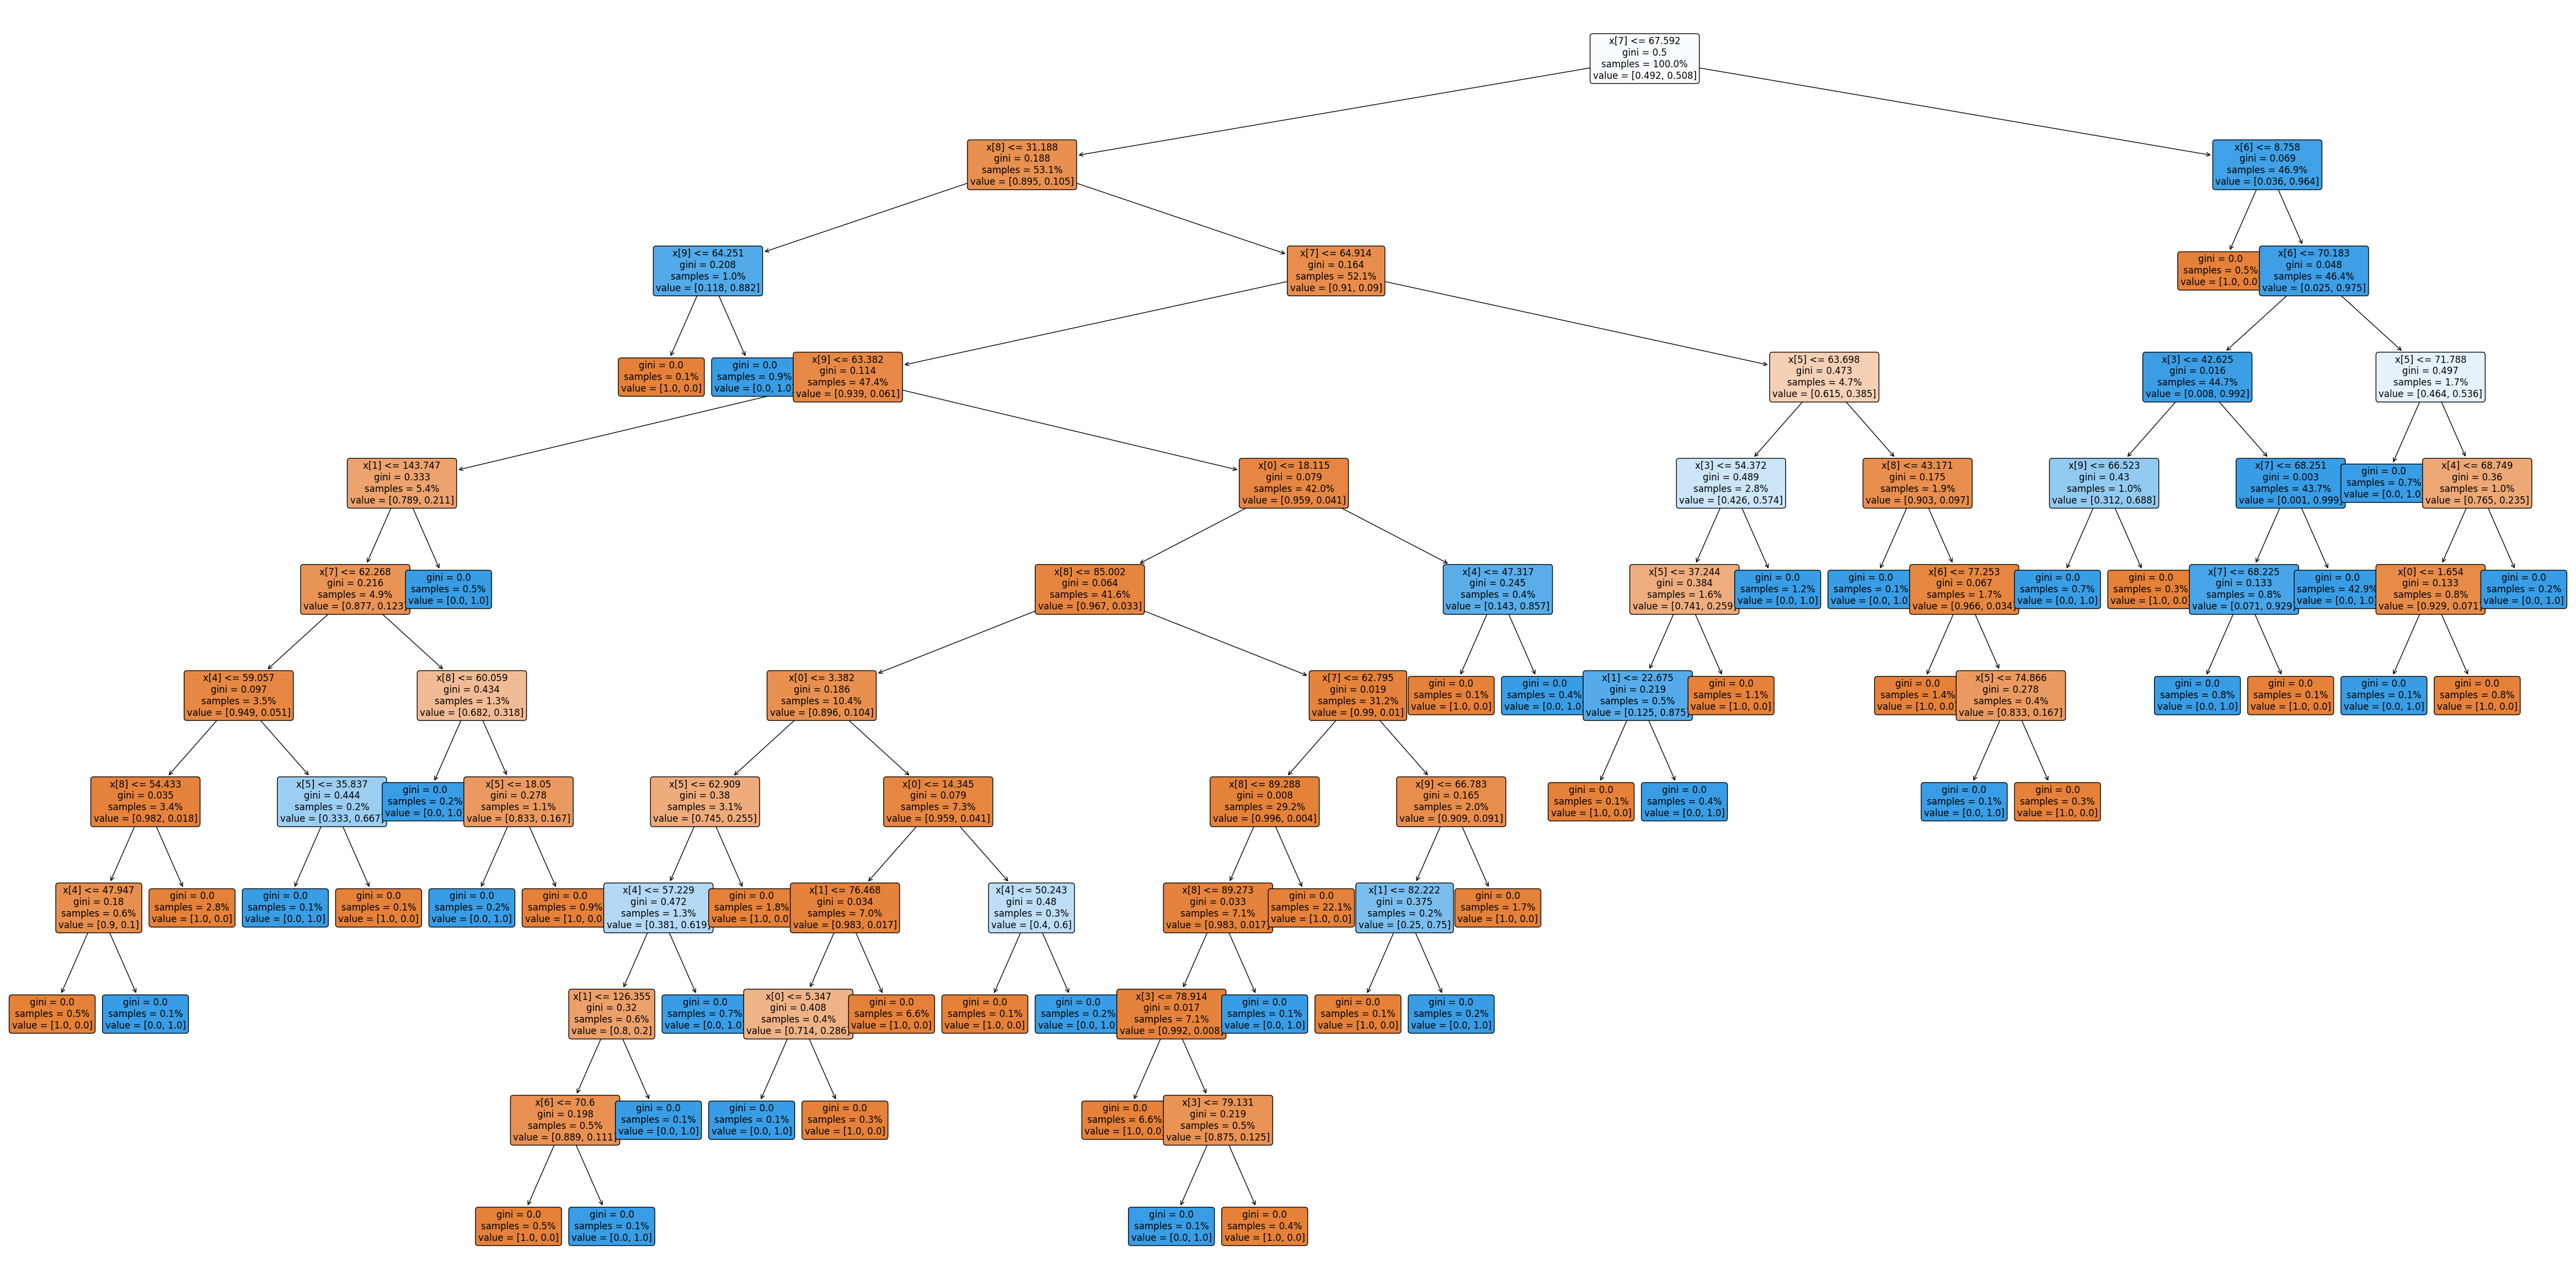

In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import plot_tree
from matplotlib import pyplot as plt


clf = DecisionTreeClassifier(random_state=RANDOM_SEED)
clf.fit(X_train, y_train)

print('Ein: %0.4f' % (1 - accuracy_score(y_train, clf.predict(X_train))))
print('Eout: %0.4f' % (1 - accuracy_score(y_test, clf.predict(X_test))))
print(classification_report(y_test, clf.predict(X_test)))

#Desenho da árvore
plt.figure(figsize=(60,30))
plot_tree(
    clf,
    filled=True, 
    proportion = True,
    fontsize=12, 
    rounded = True)
plt.show()

C:\Users\Xonas\AppData\Local\Temp\ipykernel_16256\2653623761.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


[0.         0.00068199 0.00069248 0.00072133 0.00072875 0.00073352
 0.00073782 0.00077655 0.001366   0.00141212 0.00143786 0.00149766
 0.00188797 0.00209843 0.00267866 0.00320593 0.00323666 0.00422763
 0.00459384 0.00576632 0.0062919  0.00809505 0.00815215 0.01050534
 0.01289358 0.01345557 0.36570914]
[0.         0.00136398 0.00274894 0.00419161 0.00564911 0.00711615
 0.01006744 0.01162054 0.01571854 0.01713066 0.01856852 0.02006618
 0.03328199 0.03538042 0.03805908 0.04126501 0.04450167 0.05295693
 0.05755077 0.07484972 0.08114162 0.08923666 0.09738881 0.10789415
 0.12078774 0.13424331 0.49995244]


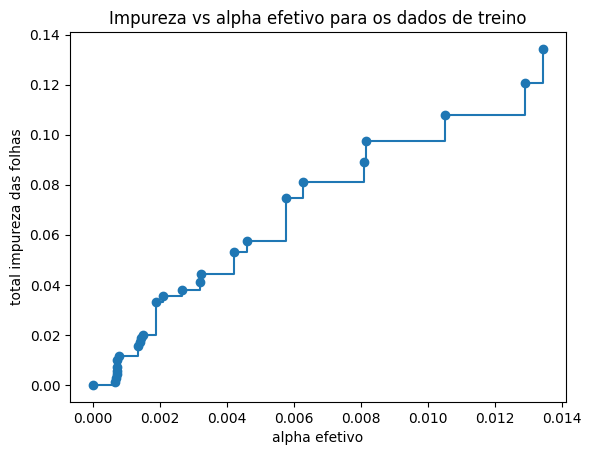

In [30]:
#Divide os dados em treino e validação 
X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train, y_train, test_size=0.20, random_state=0)

#Recupera os valores efetivos de alpha para a elaboração da fase de prunning
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

#Plota a relação entre os valores de alpha e impureza das folhas
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("alpha efetivo")
ax.set_ylabel("total impureza das folhas")
ax.set_title("Impureza vs alpha efetivo para os dados de treino")
fig.show()

print(ccp_alphas)
print(impurities)

Um alfa maior tende a trazer mais impurezas para as folhas, o ideal é encontrar um alfa que possa equilibre a quantidade de impurezas e a acuracia do modelo

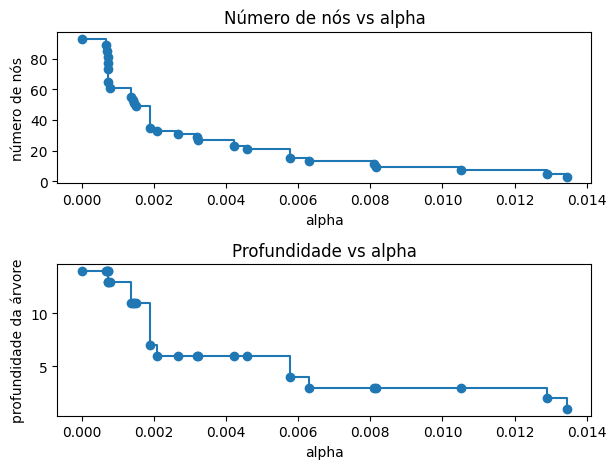

In [31]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

#Descarta o último por ser trivial (apenas o nó raiz)
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("número de nós")
ax[0].set_title("Número de nós vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("profundidade da árvore")
ax[1].set_title("Profundidade vs alpha")
fig.tight_layout()

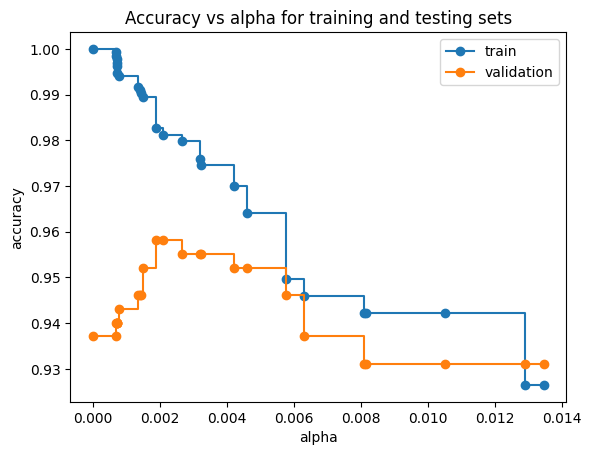

In [32]:
import matplotlib.pyplot as plt

train_scores = [clf.score(X_train, y_train) for clf in clfs]
val_scores = [clf.score(X_val, y_val) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, val_scores, marker="o", label="validation", drawstyle="steps-post")
ax.legend()
plt.show()

In [34]:
df_alphas = pd.DataFrame([ccp_alphas, train_scores, val_scores]).T
df_alphas.columns = ['alpha', 'train', 'validation']
#verificando o melhor alpha onde a acuracia de validação é maior ou igual que a de treino (não foi overfitado) 
#mas ainda sim a acuracia de treino é alta
best = df_alphas.loc[(df_alphas['train'] <= df_alphas['validation'])].sort_values(by='train', ascending=False).head(1)
best_alpha = best['alpha'].values[0]
best_alpha

0.012893582633194955

Ein: 0.0735
Eout: 0.0624
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       222
           1       0.97      0.89      0.93       195

    accuracy                           0.94       417
   macro avg       0.94      0.93      0.94       417
weighted avg       0.94      0.94      0.94       417



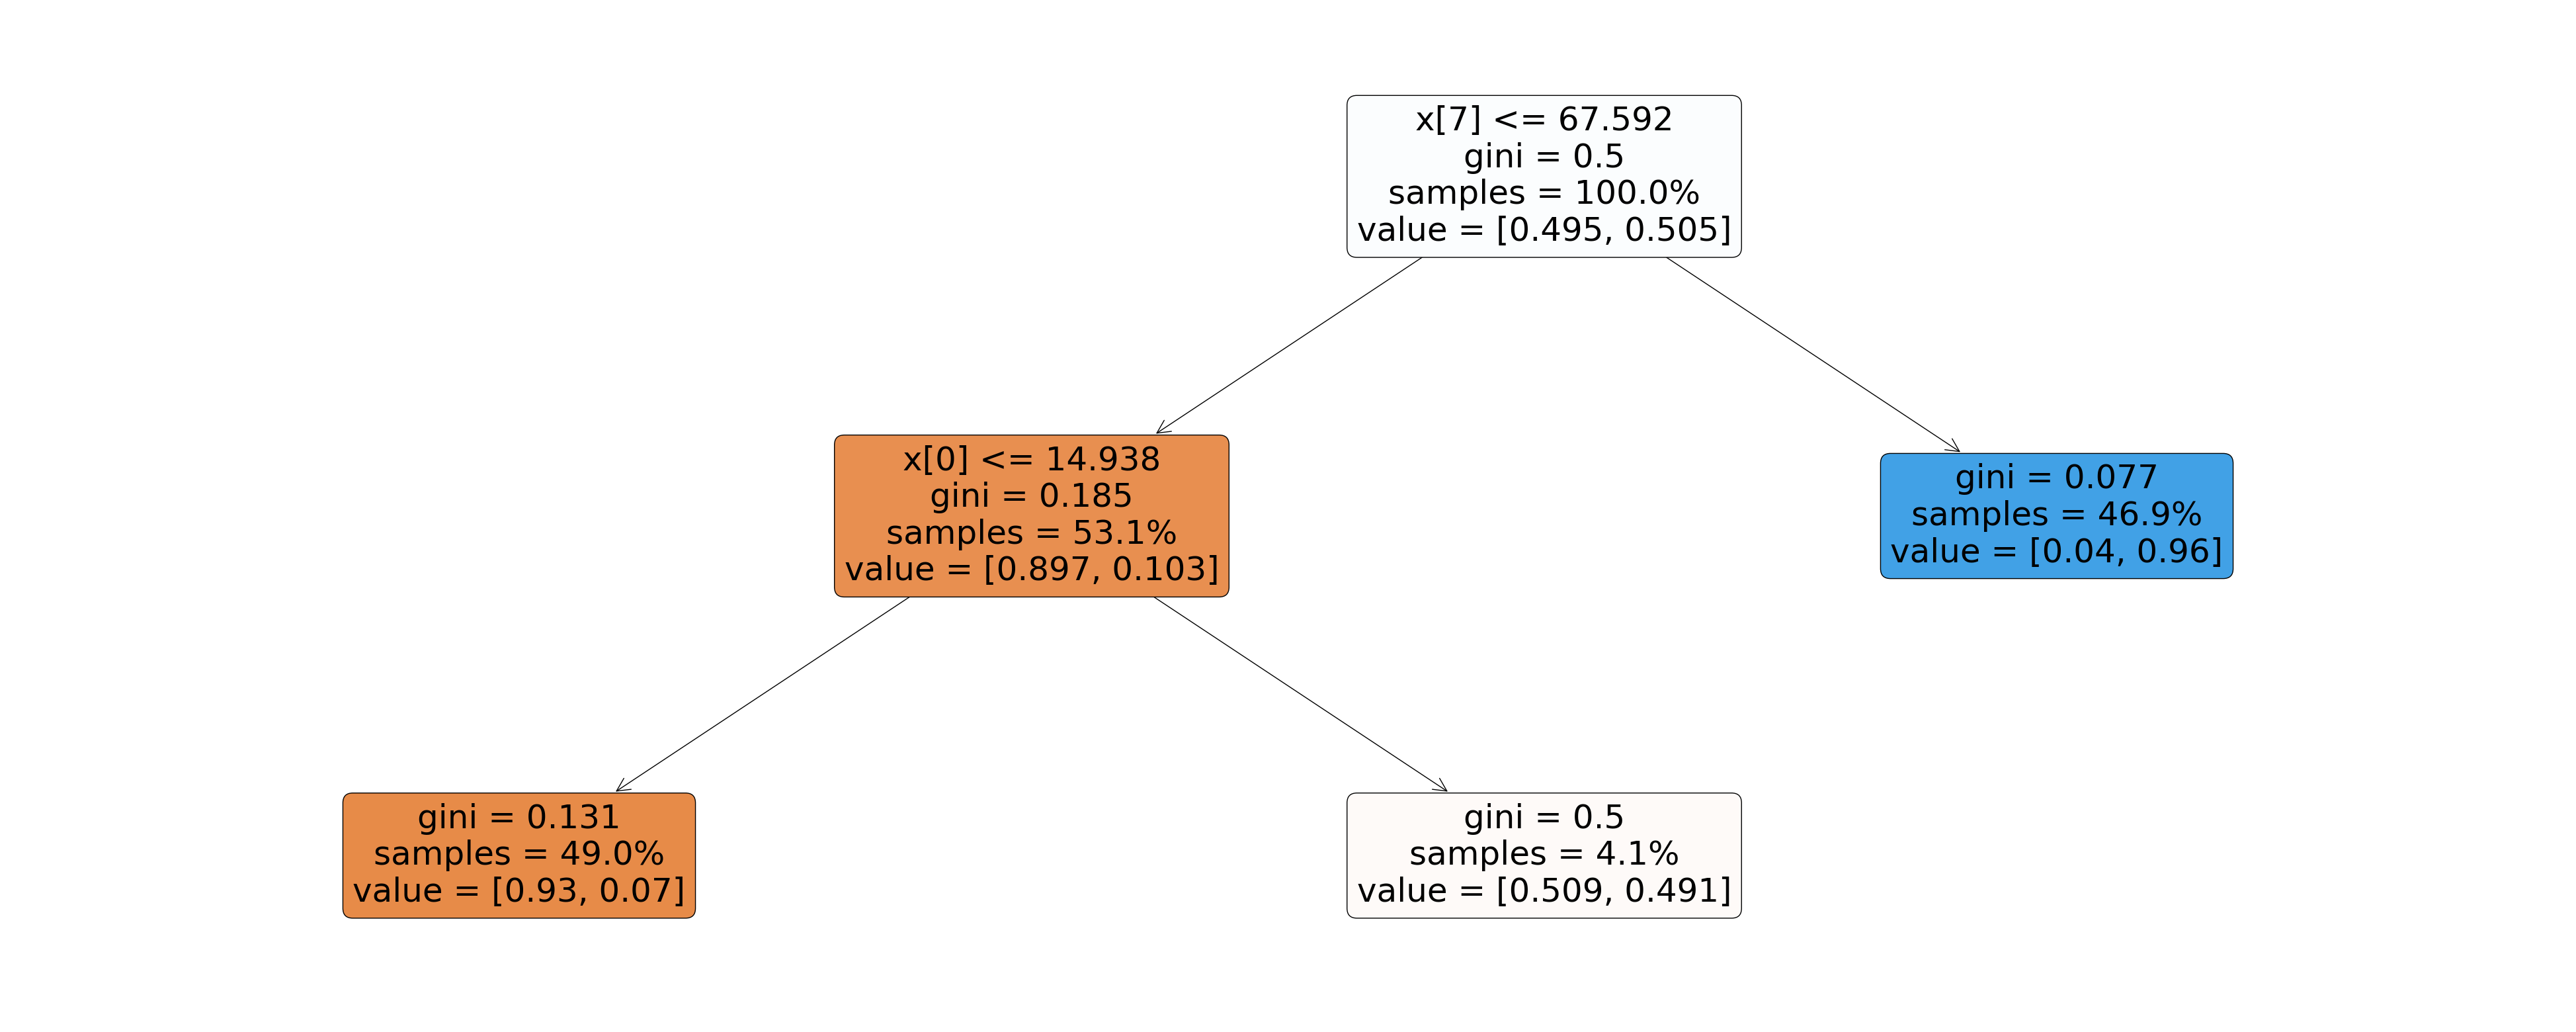

In [35]:
clf = DecisionTreeClassifier(random_state=0, ccp_alpha=best_alpha)
clf.fit(X_train, y_train)

print('Ein: %0.4f' % (1 - accuracy_score(y_train, clf.predict(X_train))))
print('Eout: %0.4f' % (1 - accuracy_score(y_test, clf.predict(X_test))))
print(classification_report(y_test, clf.predict(X_test)))

#Desenho da árvore
plt.figure(figsize=(50,20))
plot_tree(
    clf,
    filled=True, 
    proportion = True,
    fontsize=36, 
    rounded = True)
plt.show()

In [38]:
from sklearn.model_selection import GridSearchCV

clf = DecisionTreeClassifier(random_state=0)
path = clf.cost_complexity_pruning_path(X_train, y_train)

param_grid = {'ccp_alpha': path.ccp_alphas}

CV_clf = GridSearchCV(estimator=clf, param_grid=param_grid, cv = 5, verbose=2, n_jobs=-1)
CV_clf.fit(X_train, y_train)


print('Ein: %0.4f' % (1 - accuracy_score(y_train, CV_clf.predict(X_train))))
print('Eout: %0.4f' % (1 - accuracy_score(y_test, CV_clf.predict(X_test))))
print(classification_report(y_test, CV_clf.predict(X_test)))

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Ein: 0.0090
Eout: 0.0360
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       222
           1       0.96      0.96      0.96       195

    accuracy                           0.96       417
   macro avg       0.96      0.96      0.96       417
weighted avg       0.96      0.96      0.96       417

